In [8]:
# ==========================================================
# 09_RF_with_gcpal_embeddings — Setup + Load + Merge (robusto)
# ==========================================================

# --- Project root for imports/paths ---
import sys
from pathlib import Path

if "__file__" in globals():
    ROOT = Path(__file__).resolve().parents[1]
else:
    ROOT = Path.cwd().parents[0]  # notebook lives in /notebooks

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

print(f"📁 ROOT: {ROOT.resolve()}")

# --- Imports ---
import pandas as pd
import numpy as np
from src.utils import ConfigLoader

# --- Config & paths ---
cfg = ConfigLoader.load("base.yaml")

data_proc = (ROOT / cfg["paths"]["data_processed"]).resolve()
splits_dir = data_proc / "splits"
emb_dir    = data_proc / "embeddings"

print("data_processed:", data_proc)
print("splits_dir    :", splits_dir)
print("embeddings    :", emb_dir)

# --- Load labeled splits (gerados no 03) ---
df_train = pd.read_csv(splits_dir / "train_nodes.csv")
df_test1 = pd.read_csv(splits_dir / "test1_nodes.csv")
df_test2 = pd.read_csv(splits_dir / "test2_nodes.csv")

print("✅ splits shapes:",
      "train", df_train.shape,
      "test1", df_test1.shape,
      "test2", df_test2.shape)

# --- Load GCPAL embeddings (cada CSV já contém feature_* + emb_gcpal_* e pode conter 'class') ---
train_emb_raw = pd.read_csv(emb_dir / "train_embeddings_gcpal.csv")
test1_emb_raw = pd.read_csv(emb_dir / "test1_embeddings_gcpal.csv")
test2_emb_raw = pd.read_csv(emb_dir / "test2_embeddings_gcpal.csv")

print("✅ embeddings shapes (raw):",
      "train_emb", train_emb_raw.shape,
      "test1_emb", test1_emb_raw.shape,
      "test2_emb", test2_emb_raw.shape)

# --- Força 'class' única vinda dos splits ---
# 1) Removemos qualquer 'class' que venha no CSV de embeddings
train_emb = train_emb_raw.drop(columns=["class"], errors="ignore")
test1_emb = test1_emb_raw.drop(columns=["class"], errors="ignore")
test2_emb = test2_emb_raw.drop(columns=["class"], errors="ignore")

# 2) Anexamos a 'class' dos splits
lbl_train = df_train[["txId", "class"]].drop_duplicates("txId")
lbl_test1 = df_test1[["txId", "class"]].drop_duplicates("txId")
lbl_test2 = df_test2[["txId", "class"]].drop_duplicates("txId")

df_train_e = train_emb.merge(lbl_train, on="txId", how="inner")
df_test1_e = test1_emb.merge(lbl_test1, on="txId", how="inner")
df_test2_e = test2_emb.merge(lbl_test2, on="txId", how="inner")

# 3) Sanity + reorder para ['txId','class', ...]
def _reorder(df):
    cols = df.columns.tolist()
    first = [c for c in ["txId", "class"] if c in cols]
    rest  = [c for c in cols if c not in first]
    return df[first + rest]

df_train_e = _reorder(df_train_e)
df_test1_e = _reorder(df_test1_e)
df_test2_e = _reorder(df_test2_e)

print("✅ merged (with class from splits):",
      "train_e", df_train_e.shape,
      "test1_e", df_test1_e.shape,
      "test2_e", df_test2_e.shape)

# --- Feature columns ---
# AF: todas as feature_* presentes nos CSVs GCPAL
af_cols  = [c for c in df_train_e.columns if c.startswith("feature_")]
# Embeddings GCPAL: emb_gcpal_*
emb_cols = [c for c in df_train_e.columns if c.startswith("emb_gcpal_")]
af_plus_emb_cols = af_cols + emb_cols

print(f"🔹 AF cols: {len(af_cols)} | 🔹 GCPAL emb cols: {len(emb_cols)}")

# --- Build datasets para dois cenários: AF e AF + GCPAL embeddings ---
train_AF    = df_train_e[["txId", "class"] + af_cols].copy()
test1_AF    = df_test1_e[["txId", "class"] + af_cols].copy()
test2_AF    = df_test2_e[["txId", "class"] + af_cols].copy()

train_AF_EMB = df_train_e[["txId", "class"] + af_cols + emb_cols].copy()
test1_AF_EMB = df_test1_e[["txId", "class"] + af_cols + emb_cols].copy()
test2_AF_EMB = df_test2_e[["txId", "class"] + af_cols + emb_cols].copy()

print("✅ prepared datasets:",
      "\n AF           ->", train_AF.shape, test1_AF.shape, test2_AF.shape,
      "\n AF+GCPAL_EMB ->", train_AF_EMB.shape, test1_AF_EMB.shape, test2_AF_EMB.shape)


📁 ROOT: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC
data_processed: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/processed
splits_dir    : /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/processed/splits
embeddings    : /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/processed/embeddings
✅ splits shapes: train (29894, 168) test1 (9983, 168) test2 (6687, 168)
✅ embeddings shapes (raw): train_emb (29894, 296) test1_emb (9983, 296) test2_emb (6687, 296)
✅ merged (with class from splits): train_e (29894, 296) test1_e (9983, 296) test2_e (6687, 296)
🔹 AF cols: 165 | 🔹 GCPAL emb cols: 128
✅ prepared datasets: 
 AF           -> (29894, 167) (9983, 167) (6687, 167) 
 AF+GCPAL_EMB -> (29894, 295) (9983, 295) (6687, 295)


In [9]:
from src.models.baseline.runner import BaselineRunner

# seeds
seed_global = cfg.get("general", {}).get("seed", 42)
seeds = [seed_global + i for i in range(5)]

runner = BaselineRunner(cfg, seeds)

# ---- RF com AF (usa splits originais sem embeddings) ----
feature_sets_af = {"AF": af_cols}
results_rf_af = runner.run_family(
    model_key="rf",
    feature_sets=feature_sets_af,
    df_train=df_train,     # sem embeddings
    df_test1=df_test1,
    df_test2=df_test2,
)

# ---- RF com AF+GCPAL_EMB (usa dataframes com emb_gcpal_*) ----
feature_sets_af_emb = {"AF+GCPAL_EMB": af_plus_emb_cols}
results_rf_af_emb = runner.run_family(
    model_key="rf",
    feature_sets=feature_sets_af_emb,
    df_train=df_train_e,   # com embeddings GCPAL
    df_test1=df_test1_e,
    df_test2=df_test2_e,
)

# Une em um único dicionário
results_summary_rf = {**results_rf_af, **results_rf_af_emb}
print("✅ RF concluído para:", list(results_summary_rf.keys()))


✅ RF concluído para: ['RF (AF)', 'RF (AF+GCPAL_EMB)']


In [12]:
from src.results.store import ResultsStore

# garante pasta de artifacts
artifacts = (ROOT / cfg["paths"].get("artifacts", "data/artifacts")).resolve()
artifacts.mkdir(parents=True, exist_ok=True)

store_path = artifacts / "results.json"
store = ResultsStore(store_path)

# hiperparâmetros usados pelo RF (ajuste se seu YAML estiver em outra chave)
# rf_cfg = cfg["models"]["baseline"]["rf"]
rf_cfg = cfg["baselines"]["rf"]  # hiperparâmetros usados

for feat_name, runs in results_summary_rf.items():
    for r in runs:
        payload = {
            "family": "rf",
            "feature_set": feat_name,           # "AF" | "AF+GCPAL_EMB"
            "seed": r["seed"],
            "train_params": rf_cfg,
            "metrics": {
                "global": {
                    "35_42": r["Global (35–42)"],
                    "43_49": r["Global (43–49)"],
                    "35_49": r["Global (35–49)"],
                },
                "by_time_step": r["por_time_step"],
            },
        }
        # namespace separado para RF com/sem embeddings GCPAL
        ns = "rf_with_gcpal_emb" if feat_name == "AF+GCPAL_EMB" else "rf"
        store.append_run(ns, payload)

print("💾 Resultados salvos/atualizados em:", store_path)


💾 Resultados salvos/atualizados em: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/artifacts/results.json


In [13]:
# ==========================================================
# PCA nos embeddings GCPAL (fit no TREINO) + baseline n=0 (AF+GCPAL_EMB completo)
# ==========================================================
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Seleciona colunas
af_cols   = [c for c in df_train_e.columns if c.startswith("feature_")]
emb_cols  = [c for c in df_train_e.columns if c.startswith("emb_gcpal_")]
seed_glob = cfg.get("general", {}).get("seed", 42)

print(f"🔹 AF cols: {len(af_cols)} | 🔹 GCPAL emb cols: {len(emb_cols)}")

# 2) Standardize embeddings APENAS no treino (mesma transformação no test)
scaler_emb = StandardScaler(with_mean=True, with_std=True)
Z_train_emb = scaler_emb.fit_transform(df_train_e[emb_cols].values)
Z_test1_emb = scaler_emb.transform(df_test1_e[emb_cols].values)
Z_test2_emb = scaler_emb.transform(df_test2_e[emb_cols].values)

# 3) PCA (até 64 PCs ou até o nº de embeddings)
max_pcs = min(64, len(emb_cols))
pca = PCA(n_components=max_pcs, random_state=seed_glob)
Z_train_pca = pca.fit_transform(Z_train_emb)
Z_test1_pca = pca.transform(Z_test1_emb)
Z_test2_pca = pca.transform(Z_test2_emb)

print("✅ PCA fit:")
print(" - max_pcs:", max_pcs)
print(" - Z_train_pca:", Z_train_pca.shape, "| Z_test1_pca:", Z_test1_pca.shape, "| Z_test2_pca:", Z_test2_pca.shape)

# 4) Baseline n=0 = AF + TODOS os embeddings originais (sem PCA)
# (Usa os AF dos splits enriquecidos df_*_e)
Xtr_af     = df_train_e[af_cols].values
Xt1_af     = df_test1_e[af_cols].values
Xt2_af     = df_test2_e[af_cols].values

Xtr_af_emb = np.hstack([Xtr_af, df_train_e[emb_cols].values])
Xt1_af_emb = np.hstack([Xt1_af, df_test1_e[emb_cols].values])
Xt2_af_emb = np.hstack([Xt2_af, df_test2_e[emb_cols].values])

ytr = df_train_e["class"].to_numpy()
y1  = df_test1_e["class"].to_numpy()
y2  = df_test2_e["class"].to_numpy()

print("✅ Baseline n=0 (AF+GCPAL_EMB):")
print(" - train:", Xtr_af_emb.shape, " test1:", Xt1_af_emb.shape, " test2:", Xt2_af_emb.shape)


🔹 AF cols: 165 | 🔹 GCPAL emb cols: 128
✅ PCA fit:
 - max_pcs: 64
 - Z_train_pca: (29894, 64) | Z_test1_pca: (9983, 64) | Z_test2_pca: (6687, 64)
✅ Baseline n=0 (AF+GCPAL_EMB):
 - train: (29894, 293)  test1: (9983, 293)  test2: (6687, 293)


In [15]:
# ==========================================================
# Sweep de n PCs (1..max_pcs) com early-stopping (+10) usando RF
# Critério: PR-AUC no pré (35–42) — GCPAL
# ==========================================================
from src.models.baseline.factory import BaselineFactory
from sklearn.metrics import average_precision_score

seed_global = cfg.get("general", {}).get("seed", 42)

def train_eval_pr_auc_pre(Xtr, ytr, Xt1, y1, seed):
    # cria RF com os hiperparâmetros do YAML e seed fixa
    clf = BaselineFactory.from_cfg("rf", cfg, seed)
    clf.fit(Xtr, ytr)
    prob = clf.predict_proba(Xt1)[:, 1]
    # PR-AUC (média de precisão) no conjunto pré
    return average_precision_score(y1, prob)

# 1) baseline n=0 (AF + TODOS os emb_gcpal originais, sem PCA)
best_n = 0
best_pr = train_eval_pr_auc_pre(Xtr_af_emb, ytr, Xt1_af_emb, y1, seed_global)
trace = [(0, best_pr)]
print(f"n=0 (AF+GCPAL_EMB): PR-AUC(pre) = {best_pr:.4f}")

# 2) sweep com janela de parada +10
no_improve_steps = 0
patience = 30

for n in range(1, max_pcs + 1):
    # monta AF + primeiras n PCs
    Xtr_n = np.hstack([Xtr_af, Z_train_pca[:, :n]])
    Xt1_n = np.hstack([Xt1_af, Z_test1_pca[:, :n]])
    pr = train_eval_pr_auc_pre(Xtr_n, ytr, Xt1_n, y1, seed_global)
    trace.append((n, pr))
    print(f"n={n:2d}: PR-AUC(pre) = {pr:.4f} | best={best_pr:.4f} (n={best_n})")

    if pr > best_pr + 1e-9:
        best_pr = pr
        best_n = n
        no_improve_steps = 0
    else:
        no_improve_steps += 1

    if no_improve_steps >= patience:
        print(f"⏹️ Parando em n={n} (sem melhora por {patience} passos após n_best={best_n}).")
        break

# 3) Avalia o melhor n também no pós e global (opcional)
def eval_post_and_global(n):
    if n == 0:
        Xt2_use = Xt2_af_emb
    else:
        Xt2_use = np.hstack([Xt2_af, Z_test2_pca[:, :n]])

    # treina novamente com o melhor n
    if n == 0:
        Xtr_use = Xtr_af_emb
        Xt1_use = Xt1_af_emb
    else:
        Xtr_use = np.hstack([Xtr_af, Z_train_pca[:, :n]])
        Xt1_use = np.hstack([Xt1_af, Z_test1_pca[:, :n]])

    clf = BaselineFactory.from_cfg("rf", cfg, seed_global)
    clf.fit(Xtr_use, ytr)
    pr_pre  = average_precision_score(y1, clf.predict_proba(Xt1_use)[:, 1])
    pr_post = average_precision_score(y2, clf.predict_proba(Xt2_use)[:, 1])

    # global = concat test1+test2
    y_global = np.concatenate([y1, y2])
    p_global = np.concatenate([
        clf.predict_proba(Xt1_use)[:, 1],
        clf.predict_proba(Xt2_use)[:, 1],
    ])
    pr_global = average_precision_score(y_global, p_global)
    return pr_pre, pr_post, pr_global

best_pre, best_post, best_global = eval_post_and_global(best_n)

print("\n🏁 Resultado final:")
print(f" - Melhor n (PCs) = {best_n}")
print(f" - PR-AUC(pre)    = {best_pre:.4f}")
print(f" - PR-AUC(pos)    = {best_post:.4f}")
print(f" - PR-AUC(global) = {best_global:.4f}")

# Guarda a trilha para plot na próxima célula (n, pr_pre)
pca_trace = pd.DataFrame(trace, columns=["n_components", "pr_auc_pre"])


n=0 (AF+GCPAL_EMB): PR-AUC(pre) = 0.9003
n= 1: PR-AUC(pre) = 0.9059 | best=0.9003 (n=0)
n= 2: PR-AUC(pre) = 0.9088 | best=0.9059 (n=1)
n= 3: PR-AUC(pre) = 0.9094 | best=0.9088 (n=2)
n= 4: PR-AUC(pre) = 0.9050 | best=0.9094 (n=3)
n= 5: PR-AUC(pre) = 0.9078 | best=0.9094 (n=3)
n= 6: PR-AUC(pre) = 0.9060 | best=0.9094 (n=3)
n= 7: PR-AUC(pre) = 0.9040 | best=0.9094 (n=3)
n= 8: PR-AUC(pre) = 0.9077 | best=0.9094 (n=3)
n= 9: PR-AUC(pre) = 0.9024 | best=0.9094 (n=3)
n=10: PR-AUC(pre) = 0.9037 | best=0.9094 (n=3)
n=11: PR-AUC(pre) = 0.9075 | best=0.9094 (n=3)
n=12: PR-AUC(pre) = 0.9085 | best=0.9094 (n=3)
n=13: PR-AUC(pre) = 0.9012 | best=0.9094 (n=3)
n=14: PR-AUC(pre) = 0.9024 | best=0.9094 (n=3)
n=15: PR-AUC(pre) = 0.9032 | best=0.9094 (n=3)
n=16: PR-AUC(pre) = 0.9045 | best=0.9094 (n=3)
n=17: PR-AUC(pre) = 0.9030 | best=0.9094 (n=3)
n=18: PR-AUC(pre) = 0.9067 | best=0.9094 (n=3)
n=19: PR-AUC(pre) = 0.8992 | best=0.9094 (n=3)
n=20: PR-AUC(pre) = 0.9039 | best=0.9094 (n=3)
n=21: PR-AUC(pre) =

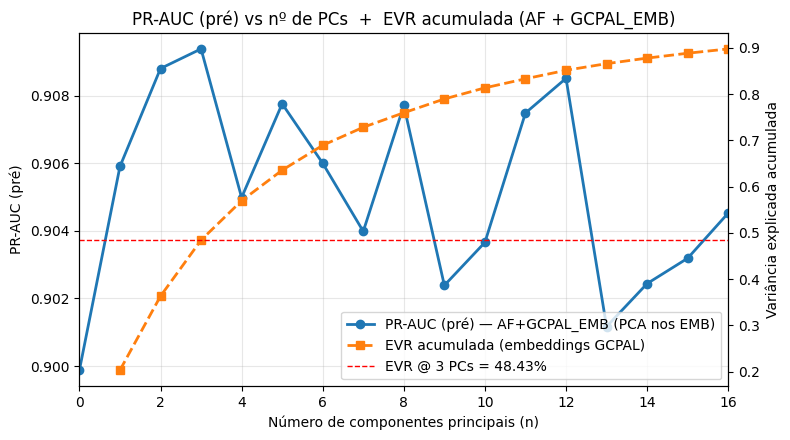

In [19]:
# ==========================================================
# PR-AUC (pré) vs nº de PCs + EVR acumulada (rápido: fit único de scaler/PCA)
# (cenário AF+GCPAL_EMB; PCA apenas nos emb_gcpal_*)
# ==========================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
from src.models.baseline.factory import BaselineFactory

seed_global = cfg.get("general", {}).get("seed", 42)

# --- Dados base (AF + EMB) ---
Xtr_af = df_train_e[af_cols].to_numpy()
Xt1_af = df_test1_e[af_cols].to_numpy()
ytr    = df_train_e["class"].to_numpy()
y1     = df_test1_e["class"].to_numpy()

Xtr_emb_all = df_train_e[emb_cols].to_numpy()
Xt1_emb_all = df_test1_e[emb_cols].to_numpy()

# --- Fit ÚNICO: scaler e PCA até n_max ---
scaler = StandardScaler(with_mean=True, with_std=True).fit(Xtr_emb_all)
Ztr = scaler.transform(Xtr_emb_all)
Zt1 = scaler.transform(Xt1_emb_all)

n_max = min(64, Ztr.shape[1])
pca_all = PCA(n_components=n_max, random_state=seed_global).fit(Ztr)
Ztr_pca = pca_all.transform(Ztr)   # (N_tr, n_max) — PCs já prontos
Zt1_pca = pca_all.transform(Zt1)   # (N_t1, n_max)

# --- Traço PR-AUC: n=0 (AF + EMB completos padronizados), depois n=1..n_max (AF + PCs[:n]) ---
def _train_eval_pr_auc_pre_rf(Xtr, ytr, Xt1, y1, seed):
    clf = BaselineFactory.from_cfg("rf", cfg, seed)
    clf.fit(Xtr, ytr)
    return average_precision_score(y1, clf.predict_proba(Xt1)[:, 1])

# n=0 (AF + TODOS embeddings sem PCA, mas padronizados)
Xtr0 = np.hstack([Xtr_af, Ztr])
Xt10 = np.hstack([Xt1_af, Zt1])
pr0  = _train_eval_pr_auc_pre_rf(Xtr0, ytr, Xt10, y1, seed_global)

trace = [(0, pr0)]
for n in range(1, n_max + 1):
    Xtr_n = np.hstack([Xtr_af, Ztr_pca[:, :n]])
    Xt1_n = np.hstack([Xt1_af, Zt1_pca[:, :n]])
    pr_n  = _train_eval_pr_auc_pre_rf(Xtr_n, ytr, Xt1_n, y1, seed_global)
    trace.append((n, pr_n))

# --- Arrays para plot ---
n_vals_pr = np.array([n for n, _ in trace])
pr_vals   = np.array([v for _, v in trace])

evr_cum = np.cumsum(pca_all.explained_variance_ratio_)  # PCs 1..n_max
n_vals_evr = np.arange(1, n_max + 1)

# --- Plot (limite x=16) ---
xmax = 16
mask_pr  = n_vals_pr  <= xmax
mask_evr = n_vals_evr <= xmax

fig, ax1 = plt.subplots(figsize=(8, 4.5))
ax2 = ax1.twinx()

ax1.plot(n_vals_pr[mask_pr], pr_vals[mask_pr],
         marker='o', linewidth=2, color='tab:blue',
         label='PR-AUC (pré) — AF+GCPAL_EMB (PCA nos EMB)')

ax2.plot(n_vals_evr[mask_evr], evr_cum[mask_evr],
         linestyle='--', marker='s', linewidth=2, color='tab:orange',
         label='EVR acumulada (embeddings GCPAL)')

# Linha horizontal na EVR @ 5 PCs (opcional)
evr_n = 3
if evr_n <= n_max:
    ax2.axhline(y=float(evr_cum[evr_n - 1]),
                color='red', linestyle='--', linewidth=1.0,
                label=f'EVR @ {evr_n} PCs = {evr_cum[evr_n - 1]:.2%}')

ax1.set_xlim(0, xmax)
ax1.set_xticks(list(range(0, xmax + 1, 2)))
ax1.set_xlabel('Número de componentes principais (n)')
ax1.set_ylabel('PR-AUC (pré)')
ax2.set_ylabel('Variância explicada acumulada')

ax1.grid(True, alpha=0.3, which='both')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='lower right')

plt.title('PR-AUC (pré) vs nº de PCs  +  EVR acumulada (AF + GCPAL_EMB)')
plt.tight_layout()
plt.show()
